Tuesday 2/03/2021

* DONE: Distill yesterday's notebook - visualize datasets and performance of a trained model
* TODO: Mount vanilla autoencoder as per Keras docs
* TODO: What distribution of latent variables tells us? Do I need normalization layers perhaps? Need early stop?

* Train data synthesis / preparation
 * Preconditioning - normalization, inversion
 * ?Linear grid spacing for angle sampling instead of random choise
 * ?Trajectories in angle/latent spaces (add 1st derivative)
* More involved network architectures
 * VAE
 * ResNet/VGG/InceptionV3 frontend
 
Runtime environment:

* autoencoder - trained model, dict keyed by ae/enc/dec - access to different layers of same network
* train, test, val - dicts with test data, keyed by A/Y/L/YY (A/Y saved in pickle files, L/YY nonpersistent)


In [56]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
import tensorflow.keras as kraes
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model, layers
%load_ext tensorboard

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Model

In [70]:
def load_models(prefix):
    model = dict()
    for k in ['ae', 'enc', 'dec']:
        fname = prefix + '-' + k + '.h5'
        model[k] = keras.models.load_model(fname)
    return model

In [71]:
autoencoder = load_models("autoencoder-double100k-2")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Dataset

### Load the dataset

In [87]:
with open('dataset-random-100k.mdict.pickle', 'rb') as handle:
    [train, val, test] = pickle.load(handle)
print(train['Y'].shape)    

(100000, 64, 64, 1)


### Visualize statistical distribution of the dataset

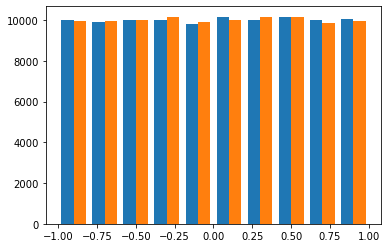

In [99]:
_=plt.hist(train['A'])

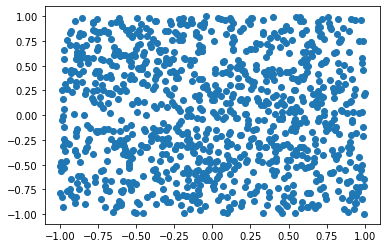

In [100]:
_=plt.scatter(train['A'][:1000,0], train['A'][:1000,1])

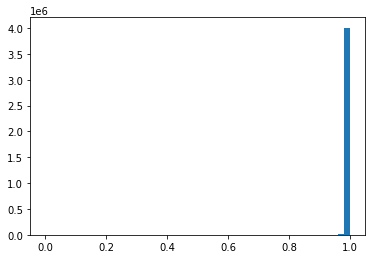

In [95]:
_=plt.hist(train['Y'][:1000].flatten(), bins=50)

### Visualize some images from the dataset

In [61]:
def _clean_ax(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
def _imshow(ax, img):
    if img is not None:
        ax.imshow(img, cmap='Greys', origin='lower')
    _clean_ax(ax)
        
def plot_Y(img_array):
    assert(img_array.shape[-1] == 1)
    fig, axs = plt.subplots(figsize=(2, 2))
    _imshow(axs, img_array[..., 0])
    return fig, axs

def plot_Ys(img_array, title=None, ncols=5):
    assert(ncols > 0)

    nimgs = img_array.shape[0]
    if nimgs == 0:
        return None, None
    elif nimgs == 1:
        return plot_Y(img_array[0,...])
    elif nimgs <= ncols:
        ncols = nimgs
        fig, axs = plt.subplots(1, ncols, figsize=(2*ncols, 2))

        for i in range(ncols):
            _imshow(axs[i], img_array[i,...])
    else:
        nrows = int((nimgs-1)/ ncols) + 1
        fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

        for i in range(nrows):
            for j in range(ncols):
                k = i*ncols + j
                if k < nimgs:
                    img = img_array[k,...]
                else:
                    img = None
                _imshow(axs[i][j], img)
                    
    if title is not None:
        fig.suptitle("%s (%s)" % (title, str(img_array.shape)))
        
    return fig, axs

In [62]:
#_=plot_Y(train_Y[0,...])
#_=plot_Ys(train_Y[0:1,...])
#_=plot_Ys(train_Y[0:5,...])
#_=plot_Ys(train_Y[0:6,...])
#_=plot_Ys(train_Y[0:24,...])

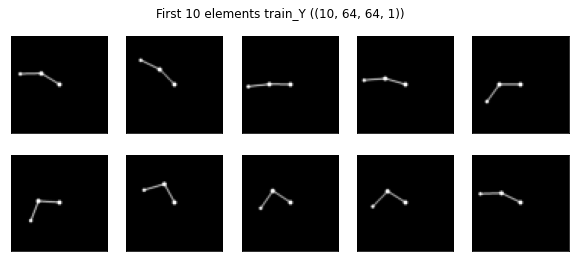

In [64]:
_=plot_Ys(train['Y'][0:10,...], title="First 10 elements train_Y")

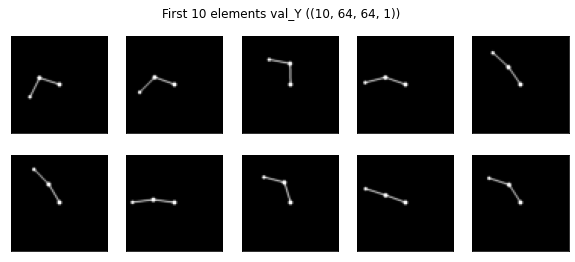

In [97]:
_=plot_Ys(val['Y'][0:10,...], title="First 10 elements val_Y")

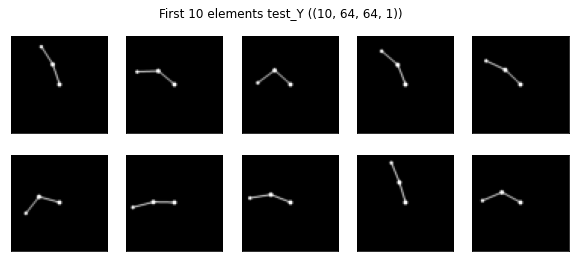

In [98]:
_=plot_Ys(test['Y'][0:10,...], title="First 10 elements test_Y")

## Dataset + results from model

## Visualize performance of the model

In [89]:
def display_xvars(data):
    nLat = data['L'].shape[0]
    nVoltages = data['A'].shape[1]

    fig, axs = plt.subplots(nLat+1, nVoltages+1)
    fig.tight_layout()

    for i in range(nLat):
      for j in range(nVoltages):
        title = "volt%d vs lat%d" % (j, i)
        axs[i][j].title.set_text(title)
        axs[i][j].plot(data['L'][i, :], data['A'][:,j], '.')

    axs[nLat][0].title.set_text("volt0 vs volt1")
    axs[nLat][0].plot(data['A'][:,1], data['A'][:,0], '.')

    axs[0][nVoltages].title.set_text("lat1 vs lat0")
    axs[0][nVoltages].plot(data['L'][0,:], data['L'][1,:], '.')

    _clean_ax(axs[1][2])
    _clean_ax(axs[2][1])
    _clean_ax(axs[2][2])

def cycle_autoencoder(ae, data, prefix="", N=10):
    Y = data['Y']
    
    print("Y.shape=" + str(Y.shape))
    L = ae['enc'].predict(Y)
    L = np.array(L)
    print("L.shape=" + str(L.shape))
    YY = ae['dec'].predict([L[0], L[1]])
    YY = np.array(YY)
    print("YY.shape=" + str(YY.shape))
    
    data['L'] = L
    data['YY'] = YY

    # - Y
    plot_Ys(Y[0:N,...], title="First %d elements of %sY" % (N, prefix))

    # - L
    fig, axs = plt.subplots(1, L.shape[0])
    fig.suptitle("Latent variables %s" % (str(L.shape)))
    for i in range(L.shape[0]):
        axs[i].hist(L[i,:])    
    
    # - YY
    plot_Ys(YY[0:N,...], title="First %d elements of %sYY" % (N, prefix))
    
    display_xvars(data)

Y.shape=(100000, 64, 64, 1)
L.shape=(2, 100000, 1)
YY.shape=(100000, 64, 64, 1)


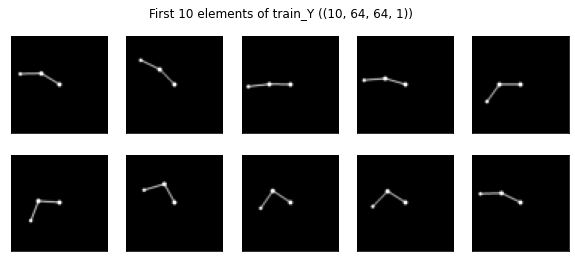

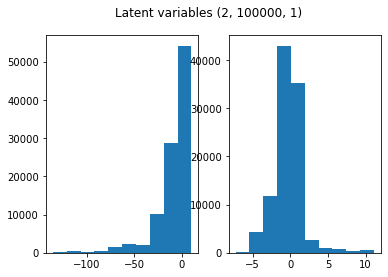

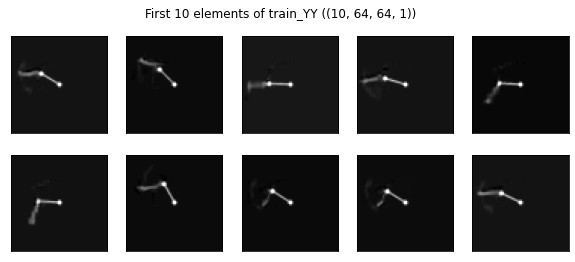

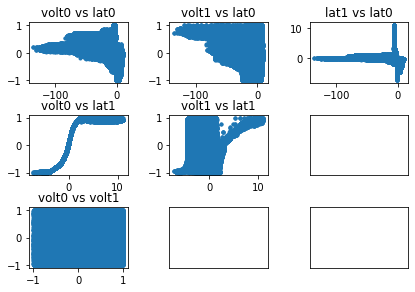

In [90]:
cycle_autoencoder(autoencoder, train, prefix="train_")

Y.shape=(100, 64, 64, 1)
L.shape=(2, 100, 1)
YY.shape=(100, 64, 64, 1)


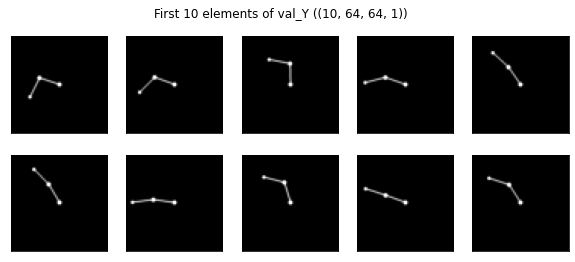

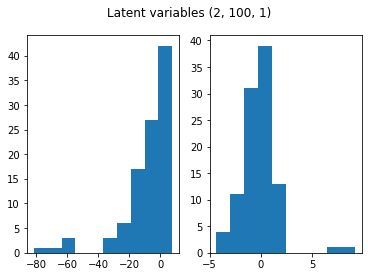

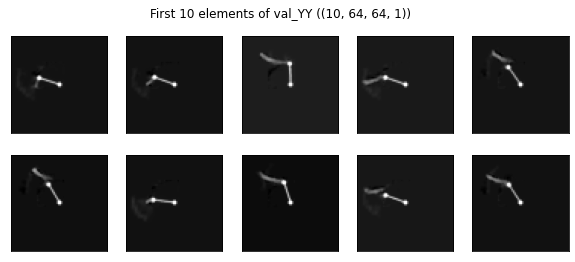

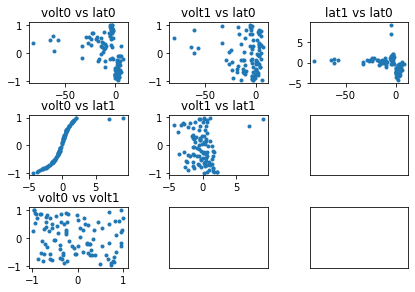

In [91]:
cycle_autoencoder(autoencoder, val, prefix="val_")

Y.shape=(100, 64, 64, 1)
L.shape=(2, 100, 1)
YY.shape=(100, 64, 64, 1)


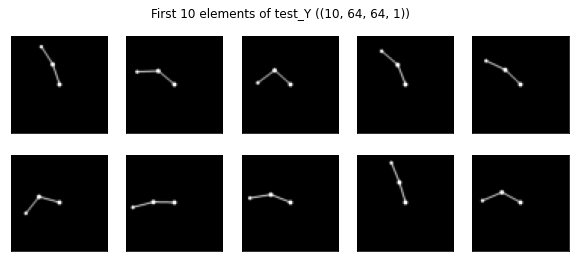

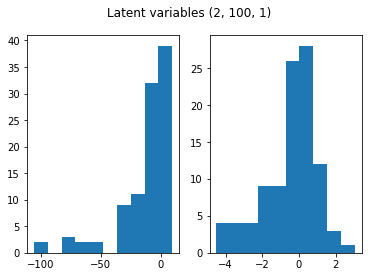

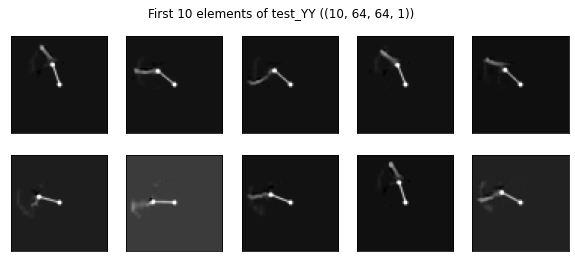

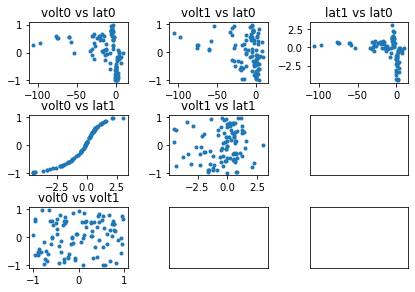

In [93]:
cycle_autoencoder(autoencoder, test, prefix="test_")

## Play with Sliders

In [38]:
import ipywidgets as widgets
from IPython.display import display

def play_with_sliders(ae):
    slider0 = widgets.FloatSlider(value=0.0, min=-5, max=1, step=0.01)
    slider1 = widgets.FloatSlider(value=0.0, min=-5, max=1, step=0.01)
    button = widgets.Button(description="Redraw")
    output = widgets.Output()

    def redraw(_=None):
        with output:
            output.clear_output(wait=True)
            #print("# %f %f" % (slider0.value, slider1.value))

            L = [np.array([[slider0.value]]), np.array([[slider1.value]])]
            Ys = ae['dec'].predict(L)[0,...,0]

            plt.clf()
            plt.imshow(Ys, cmap='Greys')
            plt.show()

    slider0.observe(redraw, names='value')
    slider1.observe(redraw, names='value')

    button.on_click(redraw)
    display(output, slider0, slider1, button)
    redraw()

In [39]:
play_with_sliders(autoencoder)

Output()

FloatSlider(value=0.0, max=1.0, min=-5.0, step=0.01)

FloatSlider(value=0.0, max=1.0, min=-5.0, step=0.01)

Button(description='Redraw', style=ButtonStyle())